In [40]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
from pandapower.plotting.plotly import pf_res_plotly
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

This pandapower network includes the following parameter tables:
   - bus (20 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (7 elements)
   - bus_geodata (20 elements)


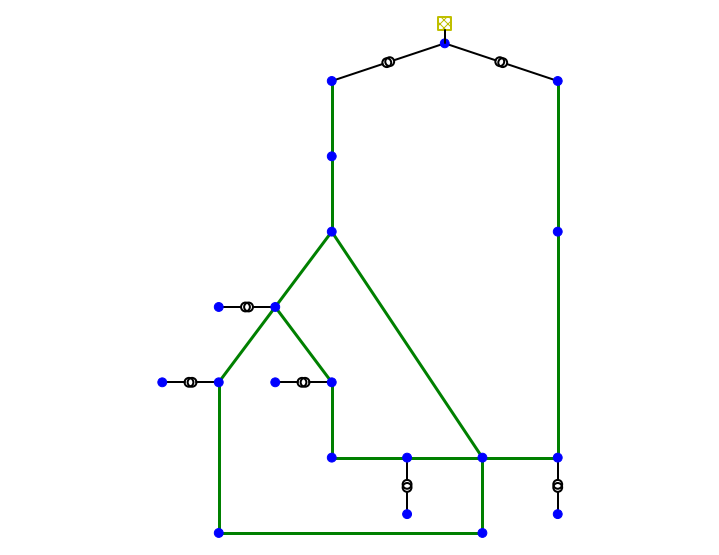

In [41]:
#creating our net
net = nw.create_cigre_network_mv()
pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9', std_type= '0.25 MVA 20/0.4 kV')

print(net)

ax = pplt.simple_plot(net, show_plot = False)
clc = pplt.create_line_collection(net, color ="g", linewidth = 3.,use_bus_geodata=(True))
pplt.draw_collections([clc], ax=ax)
plt.show()
#pp.runpp(net)

In [42]:
#importing the active and reactive power of loads from excel
df_active = pd.read_csv('active_power_time_series.csv')
df_reactive = pd.read_csv('reactive_power_time_series.csv')
# create the data source from
ds_active = DFData(df_active)
ds_reactive = DFData(df_reactive)

In [43]:
def timeseries_example(output_dir):
    
    #defing the time step
    n_timesteps = 24
    
    # 3. create controllers (to control P values of the load) ds_p is for active power and ds_q for reactive power
    create_controllers(net, ds_active, ds_reactive)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps) 

In [44]:
load_index=net.load.index
load_name=net.load.name
def create_controllers(net,ds_active, ds_reactive):
    for i in range(len(load_index)):
        ConstControl(net, element='load', variable='p_mw', element_index=load_index[i],
                 data_source=ds_active, profile_name=load_name[i])
        ConstControl(net, element='load', variable='q_mvar', element_index=load_index[i],
                 data_source=ds_reactive, profile_name=load_name[i])

In [45]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

In [46]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\jithu\AppData\Local\Temp\time_series


100%|██████████| 24/24 [00:01<00:00, 19.93it/s]


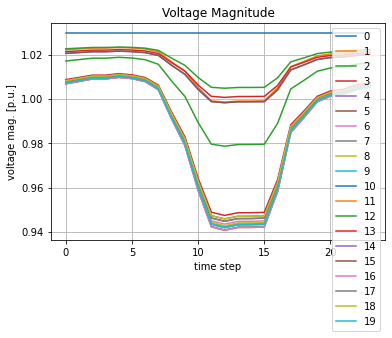

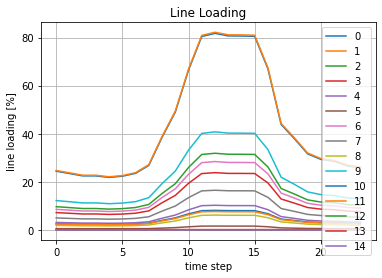

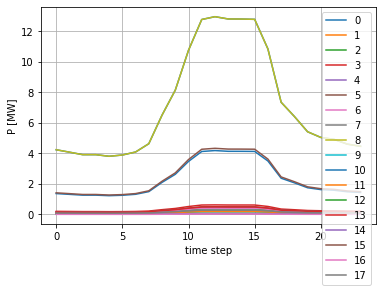

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

In [48]:
net

This pandapower network includes the following parameter tables:
   - bus (20 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (7 elements)
   - controller (36 elements)
   - bus_geodata (20 elements)
   - output_writer (1 element)
 and the following results tables:
   - res_bus (20 elements)
   - res_line (15 elements)
   - res_trafo (7 elements)
   - res_ext_grid (1 element)
   - res_load (18 elements)
   - res_switch (8 elements)

In [49]:
#-----------------------------    STEP 1.2    -----------------------

print("-----------------------------    STEP 1.2    -----------------------")

#net = nw.create_cigre_network_mv()

vmax = 1.05
vmin = 0.95
max_ll = 100

lines = net.line.index 
N = list()

for l in lines:
    net.line.loc[l,"in_service"] = False
    pp.runpp(net)
    
    
    if net.res_bus.vm_pu.max() > vmax or net.res_bus.vm_pu.min() < vmin or net.res_line.loading_percent.max() > max_ll:
        N.append(l)
        print("critical line")
        print(l)
        net.res_bus.vm_pu
        net.res_bus.vm_pu
        net.res_line.loading_percent
        
    net.line.loc[l,"in_service"] = True
    
#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, N, color ="r", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()
print(N)


-----------------------------    STEP 1.2    -----------------------
[]
